Import modules

In [11]:
import torch
torch.cuda.empty_cache()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
# Import Moudles and Packages
import gc
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD



print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

| Pytorch version: 1.10.0+cu102
| GPU: True
| Device :  cuda:0
| Device name:  Tesla T4
| Device count:  4


In [13]:
# Import local modules
from src import config as C
from src.models import hrnet, resnet, basenet

from src.utils.collate_fn import *
from src.utils.print_overwrite import *
from src.utils.seed import *
from src.utils.view_kypoints import *

from src.dataset.kface_dataset import *
from src.dataset.album_transform import *

seed_everything(C.SEED)

print(f"| Number of image : {len(C.IMAGE_LIST)}")
print(f"| Number of label : {len(C.LABEL_LIST)}")
print(f"| Number of trainset : {C.LEN_TRAIN_SET}")
print(f"| Number of validset : {C.LEN_VALID_SET}")

| Number of image : 100
| Number of label : 100
| Number of trainset : 90
| Number of validset : 10


In [14]:
len(pd.read_csv(C.LABEL_LIST[0]).values.tolist())

27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


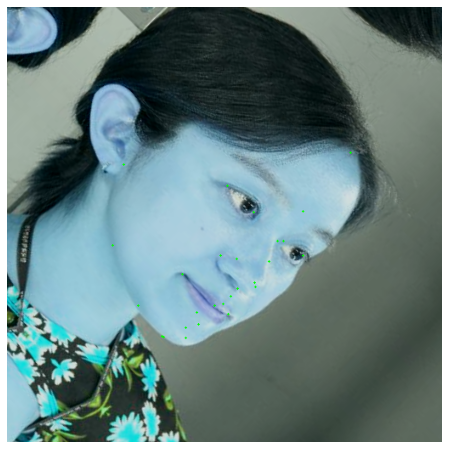

In [15]:
k_dataset_train = kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    type="train",
    transform=get_augmentation(data_type="train")
    )

k_dataset_valid = kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    type="valid",
    transform=get_augmentation(data_type="valid")
    )

# # (Option) visualize dataset
for idx, (image, landmarks) in enumerate(k_dataset_train): # torch.Size([1, 512, 512])
    if idx == 1:
        vis_keypoints(image, landmarks)

In [16]:
train_dataset, _ = D.random_split(k_dataset_train, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])
_, valid_dataset = D.random_split(k_dataset_valid, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])

train_loader = D.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = D.DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

train_images, train_landmarks = next(iter(train_loader))
valid_images, valid_landmarks = next(iter(valid_loader))

print(f"| Size of image in train_loader : {train_images.shape}")
print(f"| Size of label in train_loader : {train_landmarks.shape}")
print(f"| Size of image in train_loader : {valid_images.shape}")
print(f"| Size of label in train_loader : {valid_landmarks.shape}")

| Size of image in train_loader : torch.Size([16, 3, 512, 512])
| Size of label in train_loader : torch.Size([16, 27, 2])
| Size of image in train_loader : torch.Size([4, 3, 512, 512])
| Size of label in train_loader : torch.Size([4, 27, 2])


In [17]:
from torchvision import models

class resnet18(nn.Module):
    def __init__(self,num_classes=54):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=True)
    
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        
        return x

In [18]:
from src.models import resnet50d

In [19]:
pretrained_model = '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth'
model = resnet50d.FaceSynthetics().cpu()
if pretrained_model:
    state_dict = torch.load(pretrained_model,map_location='cpu')
    model.load_state_dict(state_dict)
model = model.to(device)

In [20]:
x = torch.randn([1, 3, 512, 512]).to(device)
out = model(x).to(device)
print(f"input : {x.shape} | output : {out.size()}")

input : torch.Size([1, 3, 512, 512]) | output : torch.Size([1, 54])


In [21]:
criterion = nn.MSELoss()
optimizer = MADGRAD(params=model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=C.EPOCHS, T_mult=1)

In [22]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

loss_min = np.inf

start_time = time.time()
for epoch in range(C.EPOCHS):
    
    model.train()
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    scaler = GradScaler()    
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, landmarks) in pbar:

        landmarks = landmarks.view(landmarks.size(0),-1)
        
        images = images.to(device)
        landmarks = landmarks.to(device)
        
        with autocast(enabled=True):
            model = model.to(device)
            
            predictions = model(images)
            loss_train_step = criterion(predictions, landmarks)
        
        scaler.scale(loss_train_step).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
                
        loss_train += loss_train_step
        running_loss = loss_train/(step+1)
        
        description = f"| # Train-Epoch : {epoch + 1} Loss : {(running_loss):.4f}"
        pbar.set_description(description)
    
    model.eval()  
    with torch.no_grad():
        
        pbar_valid = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, (images, landmarks) in pbar_valid:
                  
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        
            predictions = model(images).to(device)
                    
            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step
            running_loss = loss_valid/(step+1)

            description = f"| # Valid-Epoch : {epoch + 1} Loss : {(running_loss):.4f}"
            pbar_valid.set_description(description)
            
            
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks_kface.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, C.EPOCHS))
        print('Model Saved\n')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

| # Train-Epoch : 1 Loss : 0.0654: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 1 Loss : 0.0439: 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]



Minimum Validation Loss of 0.0439 at epoch 0/200
Model Saved



| # Train-Epoch : 2 Loss : 0.0302: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 2 Loss : 0.0231: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]



Minimum Validation Loss of 0.0231 at epoch 1/200
Model Saved



| # Train-Epoch : 3 Loss : 0.0172: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 3 Loss : 0.0194: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]



Minimum Validation Loss of 0.0194 at epoch 2/200
Model Saved



| # Train-Epoch : 4 Loss : 0.0176: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 4 Loss : 0.0169: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]



Minimum Validation Loss of 0.0169 at epoch 3/200
Model Saved



| # Train-Epoch : 5 Loss : 0.0174: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 5 Loss : 0.0132: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s]



Minimum Validation Loss of 0.0132 at epoch 4/200
Model Saved



| # Train-Epoch : 6 Loss : 0.0159: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
| # Valid-Epoch : 6 Loss : 0.0127: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]



Minimum Validation Loss of 0.0127 at epoch 5/200
Model Saved



| # Train-Epoch : 7 Loss : 0.0159: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 7 Loss : 0.0145: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]
| # Train-Epoch : 8 Loss : 0.0146: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
| # Valid-Epoch : 8 Loss : 0.0129: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]
| # Train-Epoch : 9 Loss : 0.0149: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 9 Loss : 0.0118: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]



Minimum Validation Loss of 0.0118 at epoch 8/200
Model Saved



| # Train-Epoch : 10 Loss : 0.0129: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 10 Loss : 0.0102: 100%|██████████| 3/3 [00:00<00:00,  6.98it/s]



Minimum Validation Loss of 0.0102 at epoch 9/200
Model Saved



| # Train-Epoch : 11 Loss : 0.0149: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 11 Loss : 0.0115: 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]
| # Train-Epoch : 12 Loss : 0.0135: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
| # Valid-Epoch : 12 Loss : 0.0102: 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]
| # Train-Epoch : 13 Loss : 0.0139: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 13 Loss : 0.0099: 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]



Minimum Validation Loss of 0.0099 at epoch 12/200
Model Saved



| # Train-Epoch : 14 Loss : 0.0128: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 14 Loss : 0.0101: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]
| # Train-Epoch : 15 Loss : 0.0133: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 15 Loss : 0.0108: 100%|██████████| 3/3 [00:00<00:00,  7.04it/s]
| # Train-Epoch : 16 Loss : 0.0120: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
| # Valid-Epoch : 16 Loss : 0.0099: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]



Minimum Validation Loss of 0.0099 at epoch 15/200
Model Saved



| # Train-Epoch : 17 Loss : 0.0122: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 17 Loss : 0.0113: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]
| # Train-Epoch : 18 Loss : 0.0131: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
| # Valid-Epoch : 18 Loss : 0.0094: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]



Minimum Validation Loss of 0.0094 at epoch 17/200
Model Saved



| # Train-Epoch : 19 Loss : 0.0122: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
| # Valid-Epoch : 19 Loss : 0.0090: 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]



Minimum Validation Loss of 0.0090 at epoch 18/200
Model Saved



| # Train-Epoch : 20 Loss : 0.0118: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 20 Loss : 0.0076: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]



Minimum Validation Loss of 0.0076 at epoch 19/200
Model Saved



| # Train-Epoch : 21 Loss : 0.0115: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 21 Loss : 0.0087: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]
| # Train-Epoch : 22 Loss : 0.0113: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 22 Loss : 0.0078: 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]
| # Train-Epoch : 23 Loss : 0.0106: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 23 Loss : 0.0065: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]



Minimum Validation Loss of 0.0065 at epoch 22/200
Model Saved



| # Train-Epoch : 24 Loss : 0.0117: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
| # Valid-Epoch : 24 Loss : 0.0054: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]



Minimum Validation Loss of 0.0054 at epoch 23/200
Model Saved



| # Train-Epoch : 25 Loss : 0.0105: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 25 Loss : 0.0058: 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]
| # Train-Epoch : 26 Loss : 0.0111: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
| # Valid-Epoch : 26 Loss : 0.0059: 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]
| # Train-Epoch : 27 Loss : 0.0113: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 27 Loss : 0.0063: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]
| # Train-Epoch : 28 Loss : 0.0096: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 28 Loss : 0.0054: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]



Minimum Validation Loss of 0.0054 at epoch 27/200
Model Saved



| # Train-Epoch : 29 Loss : 0.0105: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
| # Valid-Epoch : 29 Loss : 0.0048: 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]



Minimum Validation Loss of 0.0048 at epoch 28/200
Model Saved



| # Train-Epoch : 30 Loss : 0.0094: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 30 Loss : 0.0045: 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]



Minimum Validation Loss of 0.0045 at epoch 29/200
Model Saved



| # Train-Epoch : 31 Loss : 0.0092: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 31 Loss : 0.0059: 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]
| # Train-Epoch : 32 Loss : 0.0095: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
| # Valid-Epoch : 32 Loss : 0.0051: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]
| # Train-Epoch : 33 Loss : 0.0092: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 33 Loss : 0.0041: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]



Minimum Validation Loss of 0.0041 at epoch 32/200
Model Saved



| # Train-Epoch : 34 Loss : 0.0095: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 34 Loss : 0.0040: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]



Minimum Validation Loss of 0.0040 at epoch 33/200
Model Saved



| # Train-Epoch : 35 Loss : 0.0084: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
| # Valid-Epoch : 35 Loss : 0.0047: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]
| # Train-Epoch : 36 Loss : 0.0084: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 36 Loss : 0.0055: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]
| # Train-Epoch : 37 Loss : 0.0077: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 37 Loss : 0.0045: 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]
| # Train-Epoch : 38 Loss : 0.0083: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 38 Loss : 0.0039: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]



Minimum Validation Loss of 0.0039 at epoch 37/200
Model Saved



| # Train-Epoch : 39 Loss : 0.0076: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 39 Loss : 0.0049: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]
| # Train-Epoch : 40 Loss : 0.0073: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
| # Valid-Epoch : 40 Loss : 0.0049: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]
| # Train-Epoch : 41 Loss : 0.0074: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 41 Loss : 0.0054: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s]
| # Train-Epoch : 42 Loss : 0.0065: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
| # Valid-Epoch : 42 Loss : 0.0045: 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]
| # Train-Epoch : 43 Loss : 0.0076: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 43 Loss : 0.0039: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]



Minimum Validation Loss of 0.0039 at epoch 42/200
Model Saved



| # Train-Epoch : 44 Loss : 0.0068: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]
| # Valid-Epoch : 44 Loss : 0.0039: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]
| # Train-Epoch : 45 Loss : 0.0078: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 45 Loss : 0.0053: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]
| # Train-Epoch : 46 Loss : 0.0072: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 46 Loss : 0.0044: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]
| # Train-Epoch : 47 Loss : 0.0076: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
| # Valid-Epoch : 47 Loss : 0.0043: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]
| # Train-Epoch : 48 Loss : 0.0079: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 48 Loss : 0.0046: 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]
| # Train-Epoch : 49 Loss : 0.0058: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 49 Loss : 0.0038: 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]



Minimum Validation Loss of 0.0038 at epoch 48/200
Model Saved



| # Train-Epoch : 50 Loss : 0.0071: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 50 Loss : 0.0043: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]
| # Train-Epoch : 51 Loss : 0.0061: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
| # Valid-Epoch : 51 Loss : 0.0040: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]
| # Train-Epoch : 52 Loss : 0.0067: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
| # Valid-Epoch : 52 Loss : 0.0038: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]
| # Train-Epoch : 53 Loss : 0.0071: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
| # Valid-Epoch : 53 Loss : 0.0043: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]
| # Train-Epoch : 54 Loss : 0.0056: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 54 Loss : 0.0035: 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]



Minimum Validation Loss of 0.0035 at epoch 53/200
Model Saved



| # Train-Epoch : 55 Loss : 0.0057: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 55 Loss : 0.0054: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]
| # Train-Epoch : 56 Loss : 0.0063: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 56 Loss : 0.0035: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]



Minimum Validation Loss of 0.0035 at epoch 55/200
Model Saved



| # Train-Epoch : 57 Loss : 0.0061: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 57 Loss : 0.0034: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]



Minimum Validation Loss of 0.0034 at epoch 56/200
Model Saved



| # Train-Epoch : 58 Loss : 0.0065: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 58 Loss : 0.0034: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]
| # Train-Epoch : 59 Loss : 0.0066: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 59 Loss : 0.0034: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]



Minimum Validation Loss of 0.0034 at epoch 58/200
Model Saved



| # Train-Epoch : 60 Loss : 0.0070: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
| # Valid-Epoch : 60 Loss : 0.0027: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]



Minimum Validation Loss of 0.0027 at epoch 59/200
Model Saved



| # Train-Epoch : 61 Loss : 0.0056: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 61 Loss : 0.0025: 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]



Minimum Validation Loss of 0.0025 at epoch 60/200
Model Saved



| # Train-Epoch : 62 Loss : 0.0053: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
| # Valid-Epoch : 62 Loss : 0.0029: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]
| # Train-Epoch : 63 Loss : 0.0051: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 63 Loss : 0.0026: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]
| # Train-Epoch : 64 Loss : 0.0056: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 64 Loss : 0.0027: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]
| # Train-Epoch : 65 Loss : 0.0051: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 65 Loss : 0.0028: 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]
| # Train-Epoch : 66 Loss : 0.0049: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 66 Loss : 0.0029: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]
| # Train-Epoch : 67 Loss : 0.0049: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 67 Loss : 0.0027: 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]
| # Train-Epoch 


Minimum Validation Loss of 0.0021 at epoch 70/200
Model Saved



| # Train-Epoch : 72 Loss : 0.0049: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
| # Valid-Epoch : 72 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]
| # Train-Epoch : 73 Loss : 0.0053: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 73 Loss : 0.0024: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]
| # Train-Epoch : 74 Loss : 0.0048: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 74 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]
| # Train-Epoch : 75 Loss : 0.0044: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 75 Loss : 0.0024: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]
| # Train-Epoch : 76 Loss : 0.0049: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
| # Valid-Epoch : 76 Loss : 0.0034: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]
| # Train-Epoch : 77 Loss : 0.0052: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
| # Valid-Epoch : 77 Loss : 0.0031: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]
| # Train-Epoch 


Minimum Validation Loss of 0.0021 at epoch 81/200
Model Saved



| # Train-Epoch : 83 Loss : 0.0049: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 83 Loss : 0.0039: 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]
| # Train-Epoch : 84 Loss : 0.0042: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 84 Loss : 0.0029: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]
| # Train-Epoch : 85 Loss : 0.0040: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 85 Loss : 0.0019: 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]



Minimum Validation Loss of 0.0019 at epoch 84/200
Model Saved



| # Train-Epoch : 86 Loss : 0.0041: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 86 Loss : 0.0021: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]
| # Train-Epoch : 87 Loss : 0.0042: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 87 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]
| # Train-Epoch : 88 Loss : 0.0042: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 88 Loss : 0.0018: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]



Minimum Validation Loss of 0.0018 at epoch 87/200
Model Saved



| # Train-Epoch : 89 Loss : 0.0039: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 89 Loss : 0.0017: 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]



Minimum Validation Loss of 0.0017 at epoch 88/200
Model Saved



| # Train-Epoch : 90 Loss : 0.0038: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 90 Loss : 0.0018: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]
| # Train-Epoch : 91 Loss : 0.0037: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 91 Loss : 0.0020: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]
| # Train-Epoch : 92 Loss : 0.0034: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]
| # Valid-Epoch : 92 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]
| # Train-Epoch : 93 Loss : 0.0036: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 93 Loss : 0.0019: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]
| # Train-Epoch : 94 Loss : 0.0041: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 94 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]
| # Train-Epoch : 95 Loss : 0.0040: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 95 Loss : 0.0017: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]



Minimum Validation Loss of 0.0017 at epoch 94/200
Model Saved



| # Train-Epoch : 96 Loss : 0.0042: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 96 Loss : 0.0021: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]
| # Train-Epoch : 97 Loss : 0.0045: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 97 Loss : 0.0018: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]
| # Train-Epoch : 98 Loss : 0.0044: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 98 Loss : 0.0016: 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]



Minimum Validation Loss of 0.0016 at epoch 97/200
Model Saved



| # Train-Epoch : 99 Loss : 0.0037: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 99 Loss : 0.0020: 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]
| # Train-Epoch : 100 Loss : 0.0037: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]
| # Valid-Epoch : 100 Loss : 0.0015: 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]



Minimum Validation Loss of 0.0015 at epoch 99/200
Model Saved



| # Train-Epoch : 101 Loss : 0.0041: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 101 Loss : 0.0018: 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]
| # Train-Epoch : 102 Loss : 0.0037: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
| # Valid-Epoch : 102 Loss : 0.0020: 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]
| # Train-Epoch : 103 Loss : 0.0035: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 103 Loss : 0.0015: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s]



Minimum Validation Loss of 0.0015 at epoch 102/200
Model Saved



| # Train-Epoch : 104 Loss : 0.0034: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 104 Loss : 0.0013: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]



Minimum Validation Loss of 0.0013 at epoch 103/200
Model Saved



| # Train-Epoch : 105 Loss : 0.0034: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 105 Loss : 0.0015: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]
| # Train-Epoch : 106 Loss : 0.0040: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
| # Valid-Epoch : 106 Loss : 0.0012: 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]



Minimum Validation Loss of 0.0012 at epoch 105/200
Model Saved



| # Train-Epoch : 107 Loss : 0.0035: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 107 Loss : 0.0013: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]
| # Train-Epoch : 108 Loss : 0.0035: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
| # Valid-Epoch : 108 Loss : 0.0012: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]



Minimum Validation Loss of 0.0012 at epoch 107/200
Model Saved



| # Train-Epoch : 109 Loss : 0.0040: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 109 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]
| # Train-Epoch : 110 Loss : 0.0039: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 110 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]
| # Train-Epoch : 111 Loss : 0.0034: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 111 Loss : 0.0015: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]
| # Train-Epoch : 112 Loss : 0.0037: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
| # Valid-Epoch : 112 Loss : 0.0021: 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]
| # Train-Epoch : 113 Loss : 0.0029: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 113 Loss : 0.0014: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]
| # Train-Epoch : 114 Loss : 0.0033: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 114 Loss : 0.0013: 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]
| # 


Minimum Validation Loss of 0.0011 at epoch 119/200
Model Saved



| # Train-Epoch : 121 Loss : 0.0035: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 121 Loss : 0.0013: 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]
| # Train-Epoch : 122 Loss : 0.0036: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
| # Valid-Epoch : 122 Loss : 0.0009: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]



Minimum Validation Loss of 0.0009 at epoch 121/200
Model Saved



| # Train-Epoch : 123 Loss : 0.0037: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
| # Valid-Epoch : 123 Loss : 0.0013: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]
| # Train-Epoch : 124 Loss : 0.0031: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 124 Loss : 0.0017: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]
| # Train-Epoch : 125 Loss : 0.0032: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 125 Loss : 0.0012: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]
| # Train-Epoch : 126 Loss : 0.0031: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
| # Valid-Epoch : 126 Loss : 0.0016: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]
| # Train-Epoch : 127 Loss : 0.0029: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]
| # Valid-Epoch : 127 Loss : 0.0012: 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]
| # Train-Epoch : 128 Loss : 0.0031: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
| # Valid-Epoch : 128 Loss : 0.0011: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]
| # 


Minimum Validation Loss of 0.0009 at epoch 130/200
Model Saved



| # Train-Epoch : 132 Loss : 0.0028: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 132 Loss : 0.0011: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]
| # Train-Epoch : 133 Loss : 0.0032: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
| # Valid-Epoch : 133 Loss : 0.0009: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]
| # Train-Epoch : 134 Loss : 0.0027: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
| # Valid-Epoch : 134 Loss : 0.0018: 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]
| # Train-Epoch : 135 Loss : 0.0033: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
| # Valid-Epoch : 135 Loss : 0.0011: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]
| # Train-Epoch : 136 Loss : 0.0029: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 136 Loss : 0.0022: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s]
| # Train-Epoch : 137 Loss : 0.0036: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
| # Valid-Epoch : 137 Loss : 0.0010: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]
| # 


Minimum Validation Loss of 0.0008 at epoch 180/200
Model Saved



| # Train-Epoch : 182 Loss : 0.0021: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 182 Loss : 0.0009: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]
| # Train-Epoch : 183 Loss : 0.0024: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
| # Valid-Epoch : 183 Loss : 0.0012: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]
| # Train-Epoch : 184 Loss : 0.0025: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
| # Valid-Epoch : 184 Loss : 0.0011: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]
| # Train-Epoch : 185 Loss : 0.0023: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
| # Valid-Epoch : 185 Loss : 0.0011: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]
| # Train-Epoch : 186 Loss : 0.0022: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
| # Valid-Epoch : 186 Loss : 0.0014: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]
| # Train-Epoch : 187 Loss : 0.0028: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]
| # Valid-Epoch : 187 Loss : 0.0015: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]
| # 

Training Complete
Total Elapsed Time : 1142.5239834785461 s


Total number of test images: 10
Elapsed Time : 1.349804162979126


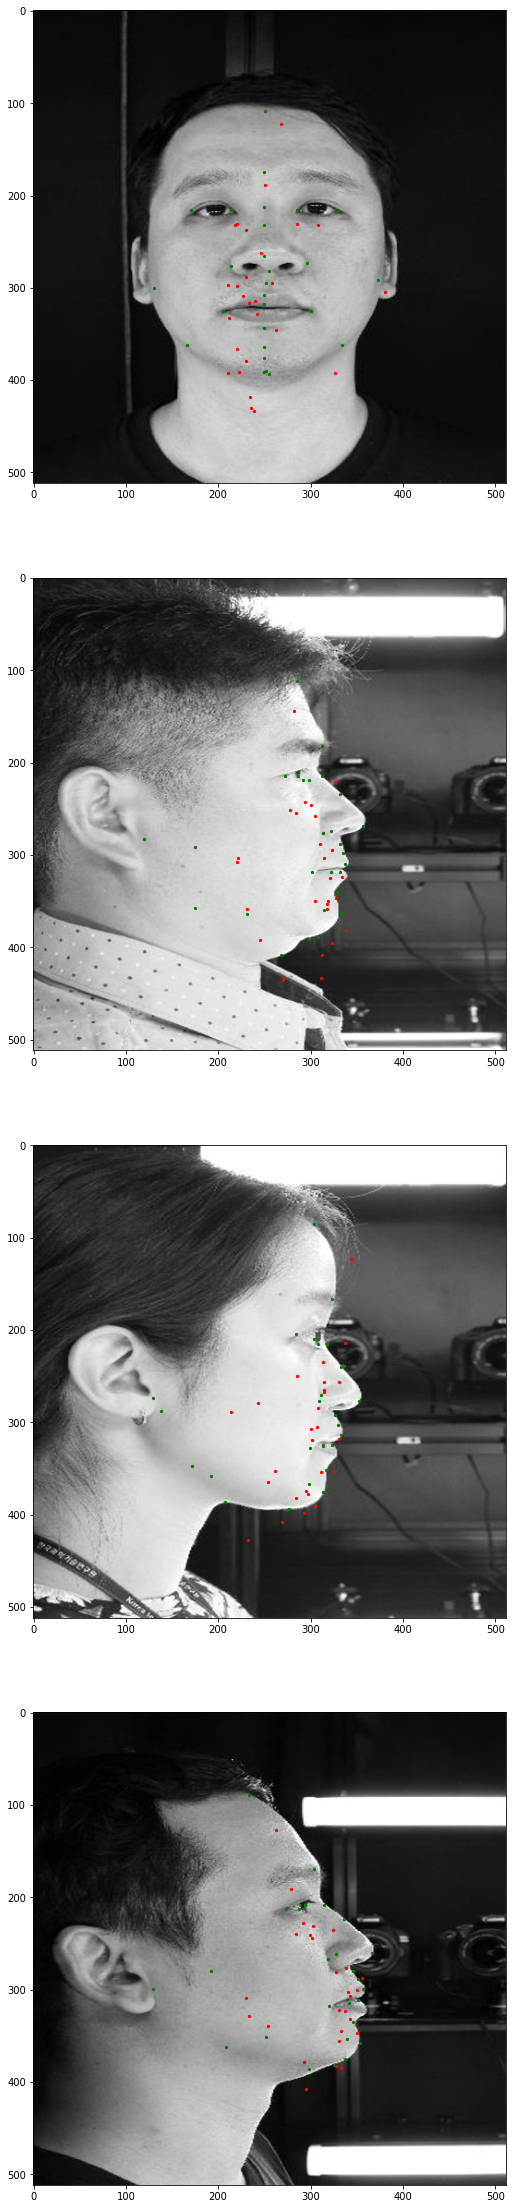

In [25]:
start_time = time.time()

with torch.no_grad():

    pretrained_model = '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks_kface.pth'
    model =  resnet50d.FaceSynthetics().cpu()
    if pretrained_model:
        state_dict = torch.load(pretrained_model,map_location='cpu')
        model.load_state_dict(state_dict)
    best_network = model.to(device)
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.to(device)
    landmarks *= 512 #* torch.tensor((512,512))    

    predictions = best_network(images).cpu()
    predictions = predictions.view([-1,27,2])
    predictions *= 512# * torch.tensor((512,512))    
    
    num_view = 4
    
    plt.figure(figsize=(10,num_view*10))
    for img_num in range(num_view):
        image = images[img_num].cpu().numpy().transpose(1,2,0).squeeze()
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        plt.subplot(num_view,1,img_num+1)
        plt.imshow(image, cmap='gray')
        plt.scatter(predictions[img_num].T[0], predictions[img_num].T[1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num].T[0], landmarks[img_num].T[1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 